# Using BERT to Identify the Narrators (Multiclass Classification)

[The previous investigation indicates that binary classification is suitable for detecting pages belonging to Bill Hardy](./2_BERT_binary_classification_bill.ipynb). 

Can this approach be extended to all narrators using multiclass classification?

In [1]:
%%capture

# make logs less verbose
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# suppress UnparsedFlagAccessError warning
import sys
from absl import flags

sys.argv = ["preserve_unused_tokens=False"]
flags.FLAGS(sys.argv)

# suppress warnings
# (after having ensured they did not impact the analysis)
import warnings

warnings.filterwarnings("ignore")

## Process data

In [2]:
import pandas as pd

df = pd.read_json("./data/jawbone.json")

Augment the data with the narrator labels.

In [3]:
import json

f = open("./data/unofficial_solution.json")
possible_solutions = json.load(f)
f.close()


def get_narrator(id):
    for key, ids in possible_solutions.items():
        if id in ids:
            return key
    return None


df = df.astype({"text": "string"})
df["narrator"] = df["page"].apply(lambda x: get_narrator(x))
df

,page,text,narrator
0,1,I sit down alone at the appointed table and ta...,Bill Hardy
1,2,I plunged for the last time. The few remaining...,Oscar Mills
2,3,"At my meeting with Clement yesterday, he had b...",John Walker
3,4,And I really think I would have preferred the ...,Bill Hardy
4,5,I hated my eye for being caught by what didn’t...,May Doncaster
...,...,...,...
95,96,Now I think I will try a cup of what they inso...,Bill Hardy
96,97,To have slept and to wake right up surrounded ...,John Walker
97,98,He stood and looked down at me; but I was not ...,Sir Paul Trinder
98,99,"And she wore a mauve love-knot on her breast, ...",Henry (dog)


Combining the pages and the suggested solution results in a series of numbered pages with a label indicating the narrators.

The data is now labeled.

## Train BERT Model

We are still using [BERT<sub>BASE</sub> uncased](https://huggingface.co/bert-base-uncased).

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import logging

logging.set_verbosity_error()  # suppress untrained weight error (unconsequential)

# use BERT base uncased model
# https://huggingface.co/bert-base-uncased
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=8
)

The number of epochs is increased (given the complexity of the classification).

In [5]:
import torch

# hyperparameters

num_epochs = 100
learning_rate = 2e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The book is sampled for training and testing in the following proportion: **5 pages per narrator**.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
df["narrator"] = label_encoder.fit_transform(df["narrator"])


def get_datasets(df):
    # sample 5% of the pages per narrator
    df_sampled = df.groupby("narrator").apply(lambda s: s.sample(5))
    print(df_sampled)

    # split datasets
    return train_test_split(
        df_sampled["text"].values,
        df_sampled["narrator"].values,
        test_size=0.2,
    )


train_texts, test_texts, train_labels, test_labels = get_datasets(df)

print(f"Train dataset size: {train_texts.shape[0]}")
print(f"Test dataset size: {test_texts.shape[0]}")

             page                                               text  narrator
narrator                                                                      
0        3      4  And I really think I would have preferred the ...         0
         29    30  I see that old dandy has purchased Cape Jasmin...         0
         16    17  I am conveniently situated, with the Moon on t...         0
         0      1  I sit down alone at the appointed table and ta...         0
         95    96  Now I think I will try a cup of what they inso...         0
1        5      6  I considered that venerable whose winter Achil...         1
         90    91  In my youth I had been worried that I bore the...         1
         58    59  What was it I held in my fingers? Looked at in...         1
         70    71  But next day that religious fellow’s head drap...         1
         74    75  I saw to it that I should be for a moment alon...         1
2        98    99  And she wore a mauve love-knot on

In [7]:
from torch.utils.data import DataLoader, Dataset


# tokenize and prepare the input data
class TokenizedData(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].flatten(),
            "attention_mask": inputs["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long),
        }


# important: set a large max_len for the pages
train_dataloader = DataLoader(
    TokenizedData(train_texts, train_labels, tokenizer, max_len=256),
    batch_size=2,
    shuffle=True,
)
test_dataloader = DataLoader(
    TokenizedData(test_texts, test_labels, tokenizer, max_len=256),
    batch_size=2,
    shuffle=False,
)

In [8]:
from transformers import AdamW
import copy


def train(dataloader):
    model = copy.copy(bert_model)
    model.to(device)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"{epoch + 1}/{num_epochs} — loss: {avg_loss:.4f}")

    return model


model = train(train_dataloader)

1/100 — loss: 2.1348
2/100 — loss: 2.0611
3/100 — loss: 1.9615
4/100 — loss: 1.7763
5/100 — loss: 1.6269
6/100 — loss: 1.4934
7/100 — loss: 1.3135
8/100 — loss: 1.1502
9/100 — loss: 1.0066
10/100 — loss: 0.8644
11/100 — loss: 0.6531
12/100 — loss: 0.5360
13/100 — loss: 0.4586
14/100 — loss: 0.3564
15/100 — loss: 0.2976
16/100 — loss: 0.2453
17/100 — loss: 0.2069
18/100 — loss: 0.1747
19/100 — loss: 0.1504
20/100 — loss: 0.1292
21/100 — loss: 0.1234
22/100 — loss: 0.1122
23/100 — loss: 0.0950
24/100 — loss: 0.0882
25/100 — loss: 0.0853
26/100 — loss: 0.0729
27/100 — loss: 0.0637
28/100 — loss: 0.0647
29/100 — loss: 0.0591
30/100 — loss: 0.0545
31/100 — loss: 0.0521
32/100 — loss: 0.0487
33/100 — loss: 0.0450
34/100 — loss: 0.0426
35/100 — loss: 0.0396
36/100 — loss: 0.0407
37/100 — loss: 0.0371
38/100 — loss: 0.0338
39/100 — loss: 0.0339
40/100 — loss: 0.0317
41/100 — loss: 0.0303
42/100 — loss: 0.0300
43/100 — loss: 0.0277
44/100 — loss: 0.0260
45/100 — loss: 0.0235
46/100 — loss: 0.02

## Prediction

In [9]:
from sklearn.metrics import accuracy_score


def eval(model, dataloader):
    model.eval()

    all_labels = []
    all_predictions = []

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].cpu().numpy()

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1).cpu().numpy()

        all_labels.extend(labels)
        all_predictions.extend(predicted_labels)

    accuracy = accuracy_score(all_labels, all_predictions)

    return all_predictions, accuracy


predicted_labels, accuracy = eval(model, test_dataloader)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2500


The accuracy of the model is very low.

In [10]:
all_dataloader = DataLoader(
    TokenizedData(df["text"], df["narrator"], tokenizer, max_len=256),
    batch_size=2,
    shuffle=True,
)
predicted_labels = eval(model, all_dataloader)

<Figure size 800x600 with 0 Axes>

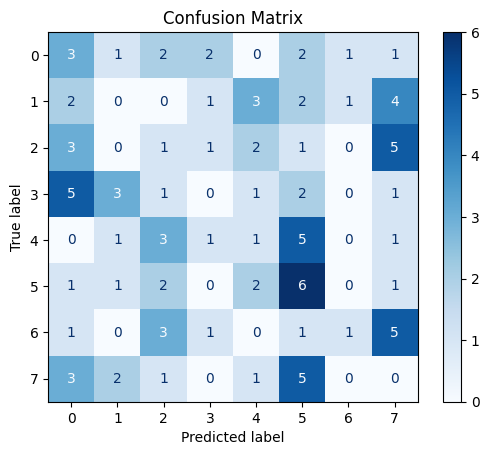

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


def generate_confusion_matrix(model, df, predicted_labels):
    true_labels = df["narrator"].values

    class_labels = sorted(df["narrator"].unique())
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format=".4g")
    plt.title("Confusion Matrix")
    plt.show()


generate_confusion_matrix(model, df, predicted_labels[0])

The confusion matrix confirms that the multiclass classification performs very poorly. 

The classification is almost random.